In [15]:
import os
import sys
import pickle
import numpy as np
from typing import Any, Dict
from optimisedGridNetwork import MixedModularCoder
from PredictionModel import OptimisedRLS
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14,10)

In [7]:
def XYZoverTime(pos_r, pos_i, pos_p):
    plt.rcParams["figure.figsize"] = (14,10)
    plt.subplot(3,1,1)
    plt.plot(pos_r[:,0], 'b-', label='real')
    plt.plot(pos_i[:,0], 'r--', label='integral')
    plt.plot(pos_p[:,0], 'g,', label='prediction')
    plt.legend()
    plt.ylabel('X')
    plt.grid()
    plt.subplot(3,1,2)
    plt.plot(pos_r[:,1], 'b-', label='real')
    plt.plot(pos_i[:,1], 'r--', label='integral')
    plt.plot(pos_p[:,1], 'g,', label='prediction')
    plt.legend()
    plt.ylabel('Y')
    plt.grid()
    plt.subplot(3,1,3)
    plt.plot(pos_r[:,2], 'b-', label='real')
    plt.plot(pos_i[:,2], 'r--', label='integral')
    plt.plot(pos_p[:,2], 'g,', label='prediction')
    plt.legend()
    plt.ylabel('Z')
    plt.xlabel('t')
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_rolling_timeseries_stats(real, predictions, window_size=200):
    """
    Plot time series for x, y, z coordinates with rolling mean and standard deviation.
    
    Parameters:
    - predictions: NumPy array of shape (n_timesteps, 3)
    - window_size: Size of the rolling window for calculating mean and std dev
    """
    # Create a figure with 3 subplots (one for each coordinate)
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    coordinates = ['X', 'Y', 'Z']
    
    for i in range(3):
        # Extract the i-th coordinate
        coord_data = predictions[:, i]
        
        # Calculate rolling mean and standard deviation using pandas-like method
        rolling_mean = np.zeros_like(coord_data)
        rolling_std = np.zeros_like(coord_data)
        
        for j in range(len(coord_data)):
            # Determine the window boundaries
            start = max(0, j - window_size // 2)
            end = min(len(coord_data), j + window_size // 2)
            
            # Calculate local statistics
            window_data = coord_data[start:end]
            rolling_mean[j] = np.mean(window_data)
            rolling_std[j] = np.std(window_data)
        
        # Plot the original time series
        axes[i].plot(np.arange(len(coord_data)), coord_data, 'g,', label='Predictions')
        axes[i].plot(np.arange(len(coord_data)), real[:, i], 'r-', label='Actual')
        
        
        # Plot the rolling mean line
        axes[i].plot(np.arange(len(coord_data)), rolling_mean, color='blue', linestyle='--', 
                     label=f'Mean (window={window_size})')
        
        # Add rolling standard deviation shading
        axes[i].fill_between(np.arange(len(coord_data)), 
                             rolling_mean - rolling_std, 
                             rolling_mean + rolling_std, 
                             color='cyan', alpha=1, 
                             label='±1 std dev')
        
        # Customize the plot
        axes[i].set_ylabel(f'{coordinates[i]} Coordinate')
        axes[i].legend()
        axes[i].grid(True, linestyle='--', alpha=0.5)
    
    axes[-1].set_xlabel('Time Steps')
    plt.tight_layout()
    plt.show()

In [10]:
## Load best gain data
filename = 'FindGains3D'
filepath = os.path.join(f"Results\\ID {filename}", f"Analysis {filename}.pickle")
with open(filepath, "rb") as f:
    data = pickle.load(f)

mse_mean = data['mse_mean']
mse_std = data['mse_std']
best_gain = data['best_gain']
best_mse = data['best_mse']
nr_gains = data['nr_gains']
range_max = data['range_max']
trials = data['trials']

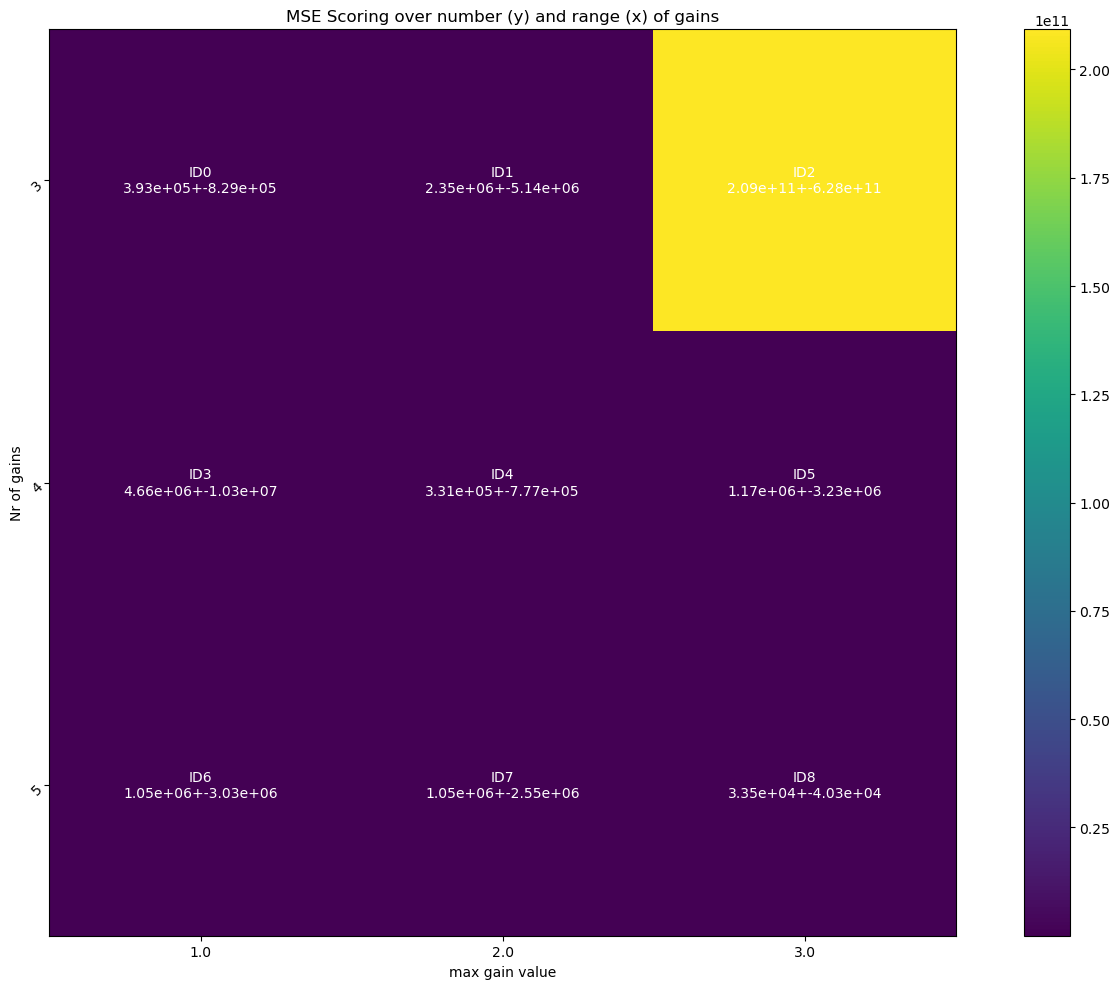

In [16]:
heatmap = np.array(mse_mean).reshape((len(nr_gains), len(range_max)))
heatmap_std = np.array(mse_std).reshape((len(nr_gains), len(range_max)))
fig, ax = plt.subplots()
im = ax.imshow(heatmap)
ax.set_ylabel('Nr of gains')
ax.set_yticks(range(len(nr_gains)), labels=nr_gains,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_xlabel('max gain value')
ax.set_xticks(range(len(range_max)), labels=range_max)

for i in range(len(nr_gains)):
    for j in range(len(range_max)):
        text = ax.text(j, i, f'ID{j+(i*len(range_max))}\n{heatmap[i, j]:.3}+-{heatmap_std[i,j]:.3}',
                       ha="center", va="center", color="w")

ax.set_title("MSE Scoring over number (y) and range (x) of gains")
fig.colorbar(im)
fig.tight_layout()
plt.savefig(f'Results\\best_gain_3D_results.png', format='png') # save in relative folder Results in Source/Repos/SelfLocalisationCF
plt.show()
plt.close()